In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

In [76]:
df = pd.read_csv('/Users/baptistecarbillet/Documents/MachineLearning1/smoking_driking_dataset_Ver01.csv')
df.drop('DRK_YN', axis=1, inplace=True)
#Male get one hot encoding
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

#Normalise df
#normalization
df.iloc[:,:-1]=  (df.iloc[:,:-1] - df.iloc[:,:-1].mean()) / (df.iloc[:,:-1].std())

random_state = 75
df_1 = df[df['SMK_stat_type_cd'] == 1.0].sample(5000,random_state=random_state)
df_2 = df[df['SMK_stat_type_cd'] == 2.0].sample(5000,random_state=random_state)
df_3 = df[df['SMK_stat_type_cd'] == 3.0].sample(5000,random_state=random_state)

X_1,y_1 = np.array(df_1.drop('SMK_stat_type_cd',axis=1)),np.array(df_1['SMK_stat_type_cd'])
X_2,y_2 = np.array(df_2.drop('SMK_stat_type_cd',axis=1)),np.array(df_2['SMK_stat_type_cd'])
X_3,y_3 = np.array(df_3.drop('SMK_stat_type_cd',axis=1)),np.array(df_3['SMK_stat_type_cd'])

from sklearn.model_selection import train_test_split

random_state = 75 #Paris

X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(X_1,y_1,test_size=0.2,random_state=random_state)
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_2,y_2,test_size=0.2,random_state=random_state)
X_train_3,X_test_3,y_train_3,y_test_3 = train_test_split(X_3,y_3,test_size=0.2,random_state=random_state)

X_train = np.concatenate((X_train_1,X_train_2,X_train_3))
y_train = np.concatenate((y_train_1,y_train_2,y_train_3))

X_test = np.concatenate((X_test_1,X_test_2,X_test_3))
y_test = np.concatenate((y_test_1,y_test_2,y_test_3))

#We shuffle the data
from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train,y_train,random_state=random_state)
X_test,y_test = shuffle(X_test,y_test,random_state=random_state)

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)

In [77]:
import torch

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train).long())

X_val = torch.from_numpy(X_val).float()
y_val = torch.squeeze(torch.from_numpy(y_val).long())

X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test).long())

#Change y_train to a (y_train shape,3) tensor depending on value
y_train = torch.nn.functional.one_hot(y_train)
y_train = y_train[:,1:]

y_val = torch.nn.functional.one_hot(y_val)

y_test = torch.nn.functional.one_hot(y_test)
y_test = y_test[:,1:]

y_val = y_val[:,1:]

In [78]:
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

In [84]:
n_input = X_train.shape[1]
n_hidden =  15

n_output = 3

class Net(torch.nn.Module):
    def __init__(self,n_input,n_hidden,n_output,activation = torch.nn.functional.relu):
        super(Net,self).__init__()
        self.hidden = torch.nn.Linear(n_input,n_hidden)
        self.activation = activation
        
        self.out = torch.nn.Linear(n_hidden,n_output)
        
    def forward(self,x):
        x = self.activation(self.hidden(x))
        
        x = self.out(x)
        
        return x

### Optim comparaison :

In [81]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train,y_train),batch_size=64,shuffle=False)
val_dataloader = DataLoader(torch.utils.data.TensorDataset(X_val,y_val),batch_size=64,shuffle=False)


In [52]:
for _,data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data


In [147]:
network = Net(n_input,n_hidden,n_output)

optimizer = torch.optim.SGD(network.parameters(),lr=0.01)
#optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
loss = torch.nn.CrossEntropyLoss()

train_score = []
val_score = []
loss_track = []
val_loss = []
Epochs = 4000

for epoch in range(Epochs):
    
    for _,data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
    
    
        optimizer.zero_grad()
        outputs = network(inputs)
        l = loss(outputs,labels)
        l.backward()
        optimizer.step()
    
    
    #Compute accuracy
    y_pred_train = network(X_train)
    y_pred_val = network(X_val)
    
    val_loss.append(loss(y_pred_val,y_val).item())
    loss_track.append(loss(y_pred_train,y_train).item())
    
    y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
    y_pred_train = torch.argmax(y_pred_train,dim=1)
    
    y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
    y_pred_val = torch.argmax(y_pred_val,dim=1)
    
    train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
    val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
    
    train_score.append(train_acc.item())
    val_score.append(val_acc.item())
    
    
    if epoch % 100 == 0:
        print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
        print('Test accuracy: {}'.format(val_acc.item()))
        print('Train accuracy: {}'.format(train_acc.item()))
        print('------------')

    #print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
    #print('Test accuracy: {}'.format(val_acc.item()))
    #print('Train accuracy: {}'.format(train_acc.item()))

Epoch: 0 - Loss: 1.096434235572815
Test accuracy: 0.39791667461395264
Train accuracy: 0.3889583349227905
------------
Epoch: 100 - Loss: 0.7910377383232117
Test accuracy: 0.6341666579246521
Train accuracy: 0.6402083039283752
------------
Epoch: 200 - Loss: 0.7781178951263428
Test accuracy: 0.6366666555404663
Train accuracy: 0.6420833468437195
------------
Epoch: 300 - Loss: 0.7706910967826843
Test accuracy: 0.6366666555404663
Train accuracy: 0.6422916650772095
------------
Epoch: 400 - Loss: 0.7652333974838257
Test accuracy: 0.637499988079071
Train accuracy: 0.6416666507720947
------------
Epoch: 500 - Loss: 0.7590427398681641
Test accuracy: 0.6354166865348816
Train accuracy: 0.6432291865348816
------------
Epoch: 600 - Loss: 0.7511299848556519
Test accuracy: 0.6362500190734863
Train accuracy: 0.6440625190734863
------------
Epoch: 700 - Loss: 0.7421630620956421
Test accuracy: 0.6341666579246521
Train accuracy: 0.6458333134651184
------------
Epoch: 800 - Loss: 0.7359708547592163
Test 

In [129]:
'''
###Without DataLoader

network = Net(n_input,n_hidden,n_output)

optimizer = torch.optim.SGD(network.parameters(),lr=0.01)

loss = torch.nn.CrossEntropyLoss()

train_score = []
val_score = []
loss_track = []
val_loss = []
Epochs = 1000

for epoch in range(Epochs):
    optimizer.zero_grad()
    y_pred = network(X_train)
    l = loss(y_pred,y_train)
    l.backward()
    optimizer.step()
    
    
    #Compute accuracy
    val_loss.append(loss(network(X_val),y_val).item())
    val_pred = torch.nn.functional.softmax(network(X_val),dim=1)
    
    val_pred = torch.argmax(val_pred,dim=1)
    
    val_acc = (val_pred == torch.argmax(y_val,dim=1)).float().mean()
    
    val_score.append(val_acc.item())
    
    
    train_pred = torch.nn.functional.softmax(y_pred,dim=1)
    train_pred = torch.argmax(train_pred,dim=1)
    train_acc = (train_pred == torch.argmax(y_train,dim=1)).float().mean()
    
    train_score.append(train_acc.item())
    
    loss_track.append(l.item())
    
    
    if epoch % 1000 == 0:
        print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
        print('Test accuracy: {}'.format(val_acc.item()))
        print('Train accuracy: {}'.format(train_acc.item()))
'''
        

Epoch: 0 - Loss: 1.1704236268997192
Test accuracy: 0.3333333432674408
Train accuracy: 0.33375000953674316


SGD

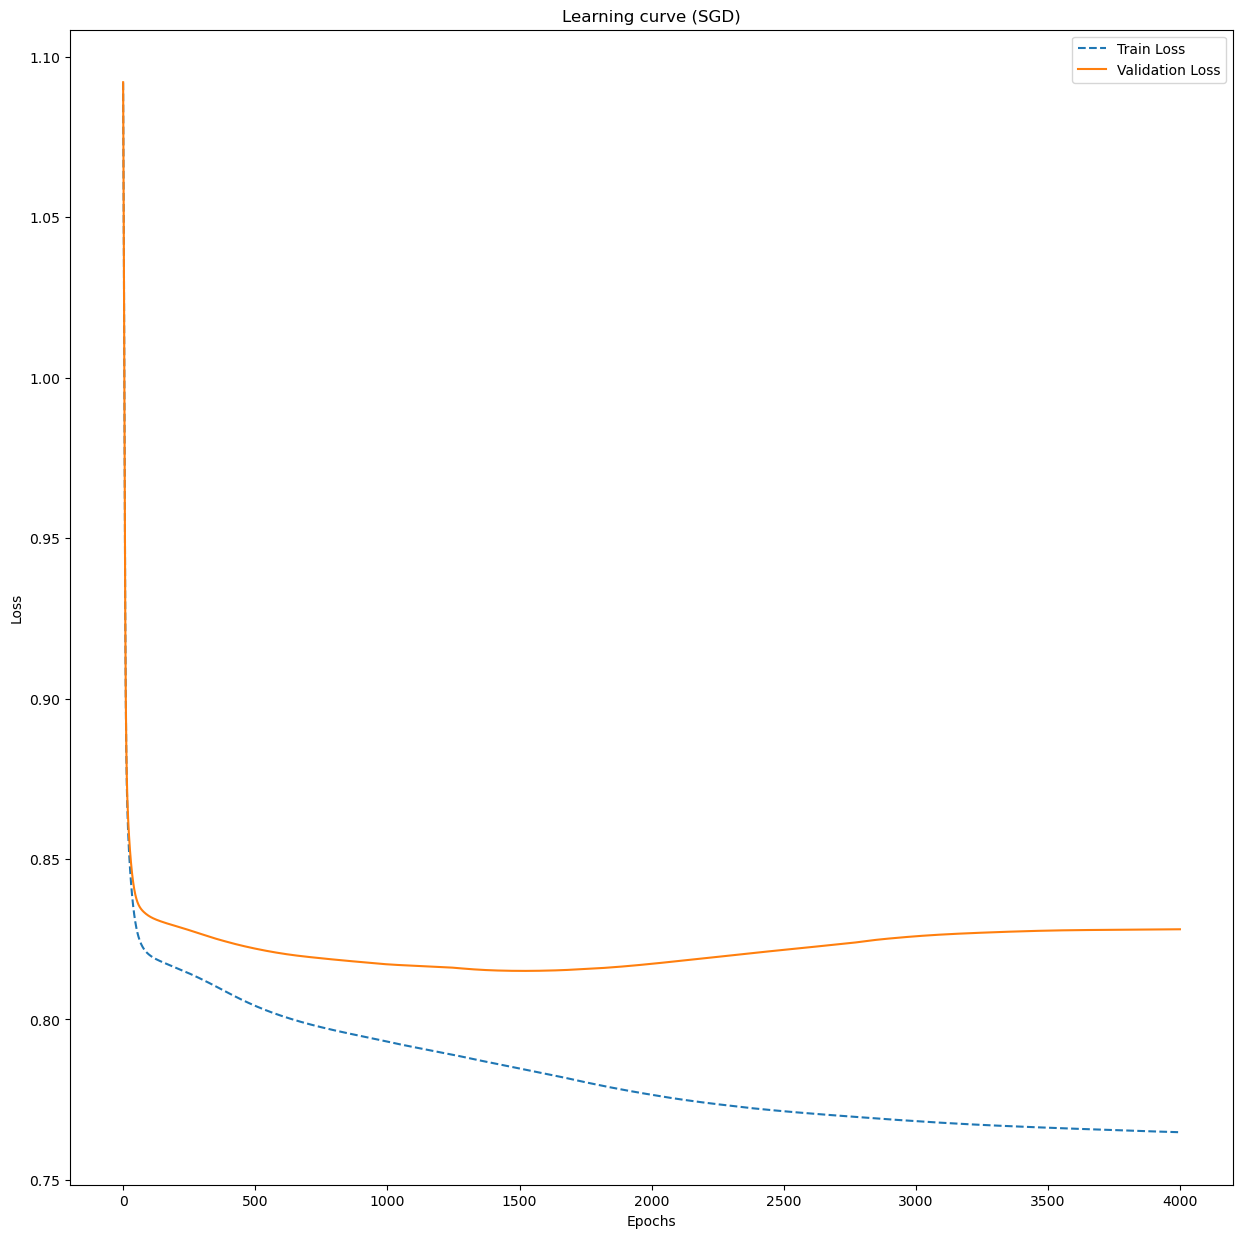

In [148]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.plot(loss_track,label='Train Loss',linestyle='--')
ax.plot(val_loss,label='Validation Loss')
ax.set_title('Learning curve (SGD)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

ADAM

In [165]:
network = Net(n_input,n_hidden,n_output)

optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
#optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
loss = torch.nn.CrossEntropyLoss()

train_score = []
val_score = []
loss_track = []
val_loss = []
Epochs = 75

for epoch in range(Epochs):
    
    for _,data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
    
    
        optimizer.zero_grad()
        outputs = network(inputs)
        l = loss(outputs,labels)
        l.backward()
        optimizer.step()
    
    
    #Compute accuracy
    y_pred_train = network(X_train)
    y_pred_val = network(X_val)
    
    val_loss.append(loss(y_pred_val,y_val).item())
    loss_track.append(loss(y_pred_train,y_train).item())
    
    y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
    y_pred_train = torch.argmax(y_pred_train,dim=1)
    
    y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
    y_pred_val = torch.argmax(y_pred_val,dim=1)
    
    train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
    val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
    
    train_score.append(train_acc.item())
    val_score.append(val_acc.item())
    
    
    if epoch % 100 == 0:
        print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
        print('Test accuracy: {}'.format(val_acc.item()))
        print('Train accuracy: {}'.format(train_acc.item()))
        print('------------')

    #print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
    #print('Test accuracy: {}'.format(val_acc.item()))
    #print('Train accuracy: {}'.format(train_acc.item()))

Epoch: 0 - Loss: 0.8328516483306885
Test accuracy: 0.622083306312561
Train accuracy: 0.6264583468437195
------------


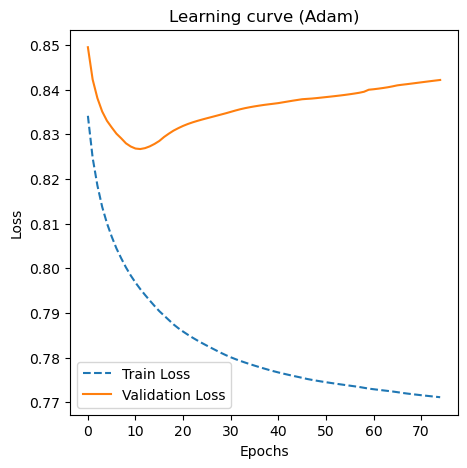

In [160]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(loss_track,label='Train Loss',linestyle='--')
ax.plot(val_loss,label='Validation Loss')
ax.set_title('Learning curve (Adam)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()


plt.show()

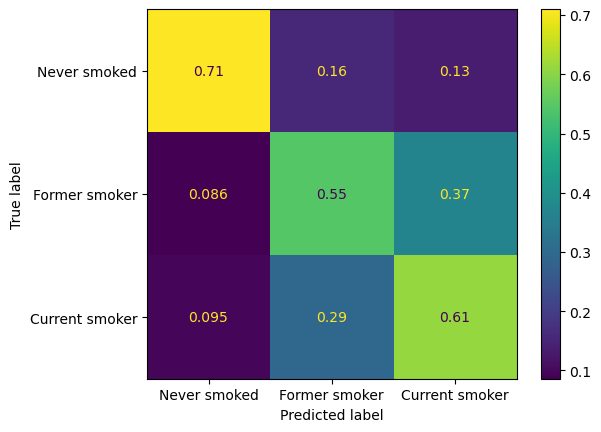

In [161]:
y_pred = network(X_val)
y_pred = torch.nn.functional.softmax(y_pred,dim=1)
y_pred = torch.argmax(y_pred,dim=1)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(torch.argmax(y_val,dim= 1),y_pred,normalize='true')
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'])
disp.plot()


## Parameter tuning

In [ ]:
## Two learning rates

network = Net(n_input,n_hidden,n_output)

optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
#optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
loss = torch.nn.CrossEntropyLoss()

train_score = []
val_score = []
loss_track = []
val_loss = []
Epochs = 75

for epoch in range(Epochs):
    
    for _,data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
    
    
        optimizer.zero_grad()
        outputs = network(inputs)
        l = loss(outputs,labels)
        l.backward()
        optimizer.step()
    
    
    #Compute accuracy
    y_pred_train = network(X_train)
    y_pred_val = network(X_val)
    
    val_loss.append(loss(y_pred_val,y_val).item())
    loss_track.append(loss(y_pred_train,y_train).item())
    
    y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
    y_pred_train = torch.argmax(y_pred_train,dim=1)
    
    y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
    y_pred_val = torch.argmax(y_pred_val,dim=1)
    
    train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
    val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
    
    train_score.append(train_acc.item())
    val_score.append(val_acc.item())
    
    
    if epoch % 100 == 0:
        print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
        print('Test accuracy: {}'.format(val_acc.item()))
        print('Train accuracy: {}'.format(train_acc.item()))
        print('------------')

## Activation tuning ;

In [79]:
activation = [torch.nn.functional.sigmoid,torch.nn.functional.relu,torch.nn.functional.tanh]

In [94]:
n_hidden = 15

In [102]:


train_score = {}
val_score = {}
loss_track = {}
val_loss = {}
Epochs = 75


for acti  in activation:

    network = Net(n_input,n_hidden,n_output,acti)

    optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
    
    loss = torch.nn.CrossEntropyLoss()

    train_score[acti] = []
    val_score[acti] = []
    loss_track[acti] = []
    val_loss[acti] = []

    for epoch in range(Epochs):
        
        for _,data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data
        
        
            optimizer.zero_grad()
            outputs = network(inputs)
            l = loss(outputs,labels)
            l.backward()
            optimizer.step()
        
        
        #Compute accuracy
        y_pred_train = network(X_train)
        y_pred_val = network(X_val)
        
        val_loss[acti].append(loss(y_pred_val,y_val).item())
        loss_track[acti].append(loss(y_pred_train,y_train).item())
        
        y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
        y_pred_train = torch.argmax(y_pred_train,dim=1)
        
        y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
        y_pred_val = torch.argmax(y_pred_val,dim=1)
        
        train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
        val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
        
        train_score[acti].append(train_acc.item())
        val_score[acti].append(val_acc.item())
        
        
        if epoch % 100 == 0:
            print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
            print('Test accuracy: {}'.format(val_acc.item()))
            print('Train accuracy: {}'.format(train_acc.item()))
            print('------------')

Epoch: 0 - Loss: 0.8221840858459473
Test accuracy: 0.6208333373069763
Train accuracy: 0.6269791722297668
------------
Epoch: 0 - Loss: 0.7694029808044434
Test accuracy: 0.6166666746139526
Train accuracy: 0.6369791626930237
------------
Epoch: 0 - Loss: 0.7963417768478394
Test accuracy: 0.6187499761581421
Train accuracy: 0.6352083086967468
------------


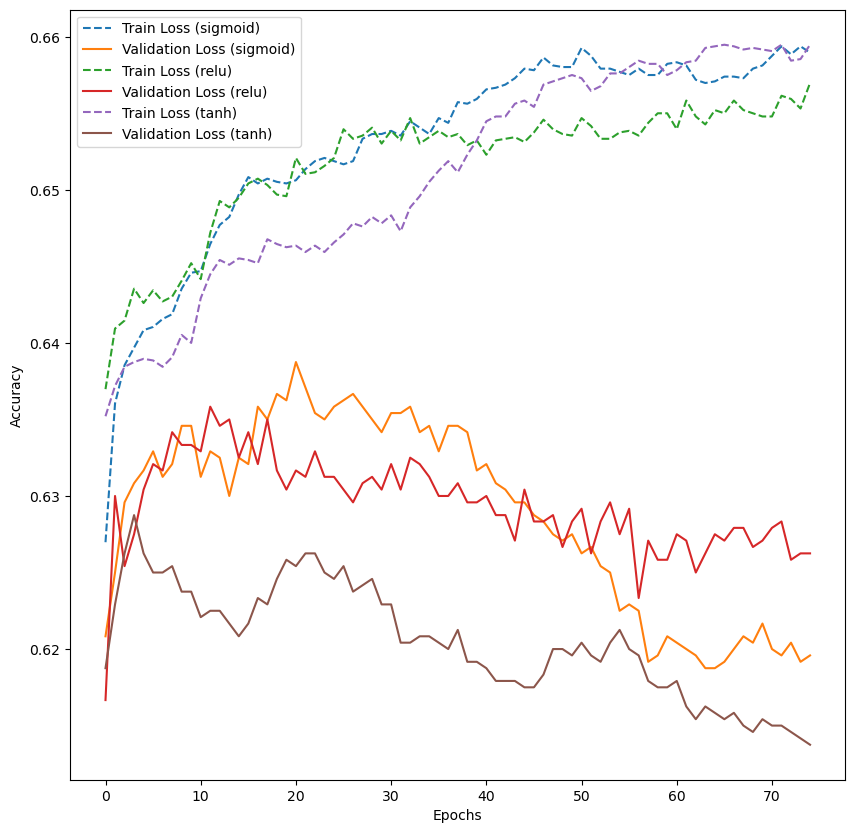

In [103]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(train_score[torch.nn.functional.sigmoid],label='Train Loss (sigmoid)',linestyle='--')
ax.plot(val_score[torch.nn.functional.sigmoid],label='Validation Loss (sigmoid)')
ax.plot(train_score[torch.nn.functional.relu],label='Train Loss (relu)',linestyle='--')
ax.plot(val_score[torch.nn.functional.relu],label='Validation Loss (relu)')
ax.plot(train_score[torch.nn.functional.tanh],label='Train Loss (tanh)',linestyle='--')
ax.plot(val_score[torch.nn.functional.tanh],label='Validation Loss (tanh)')
#ax.set_title()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()



### Different learning rate

In [184]:


train_score = {}
val_score = {}
loss_track = {}
val_loss = {}
Epochs = 200


for acti in [0.1,0.01,0.001,0.0001]:

    network = Net(n_input,n_hidden,n_output)

    optimizer = torch.optim.Adam(network.parameters(),lr=acti)
    #optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
    loss = torch.nn.CrossEntropyLoss()

    train_score[acti] = []
    val_score[acti] = []
    loss_track[acti] = []
    val_loss[acti] = []

    for epoch in range(Epochs):
        
        for _,data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data
        
        
            optimizer.zero_grad()
            outputs = network(inputs)
            l = loss(outputs,labels)
            l.backward()
            optimizer.step()
        
        
        #Compute accuracy
        y_pred_train = network(X_train)
        y_pred_val = network(X_val)
        
        val_loss[acti].append(loss(y_pred_val,y_val).item())
        loss_track[acti].append(loss(y_pred_train,y_train).item())
        
        y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
        y_pred_train = torch.argmax(y_pred_train,dim=1)
        
        y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
        y_pred_val = torch.argmax(y_pred_val,dim=1)
        
        train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
        val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
        
        train_score[acti].append(train_acc.item())
        val_score[acti].append(val_acc.item())
        
        
        if epoch % 100 == 0:
            print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
            print('Test accuracy: {}'.format(val_acc.item()))
            print('Train accuracy: {}'.format(train_acc.item()))
            print('------------')

Epoch: 0 - Loss: 0.84934002161026
Test accuracy: 0.5912500023841858
Train accuracy: 0.612708330154419
------------
Epoch: 100 - Loss: 0.8379402160644531
Test accuracy: 0.5712500214576721
Train accuracy: 0.6120833158493042
------------
Epoch: 0 - Loss: 0.8254669308662415
Test accuracy: 0.6225000023841858
Train accuracy: 0.629895806312561
------------
Epoch: 100 - Loss: 0.7428284287452698
Test accuracy: 0.625
Train accuracy: 0.6653125286102295
------------
Epoch: 0 - Loss: 1.0140694379806519
Test accuracy: 0.5295833349227905
Train accuracy: 0.5444791913032532
------------
Epoch: 100 - Loss: 0.7358411550521851
Test accuracy: 0.6379166841506958
Train accuracy: 0.6518750190734863
------------
Epoch: 0 - Loss: 1.1011860370635986
Test accuracy: 0.34583333134651184
Train accuracy: 0.3401041626930237
------------
Epoch: 100 - Loss: 0.8059324622154236
Test accuracy: 0.6274999976158142
Train accuracy: 0.6405208110809326
------------


Learning curve

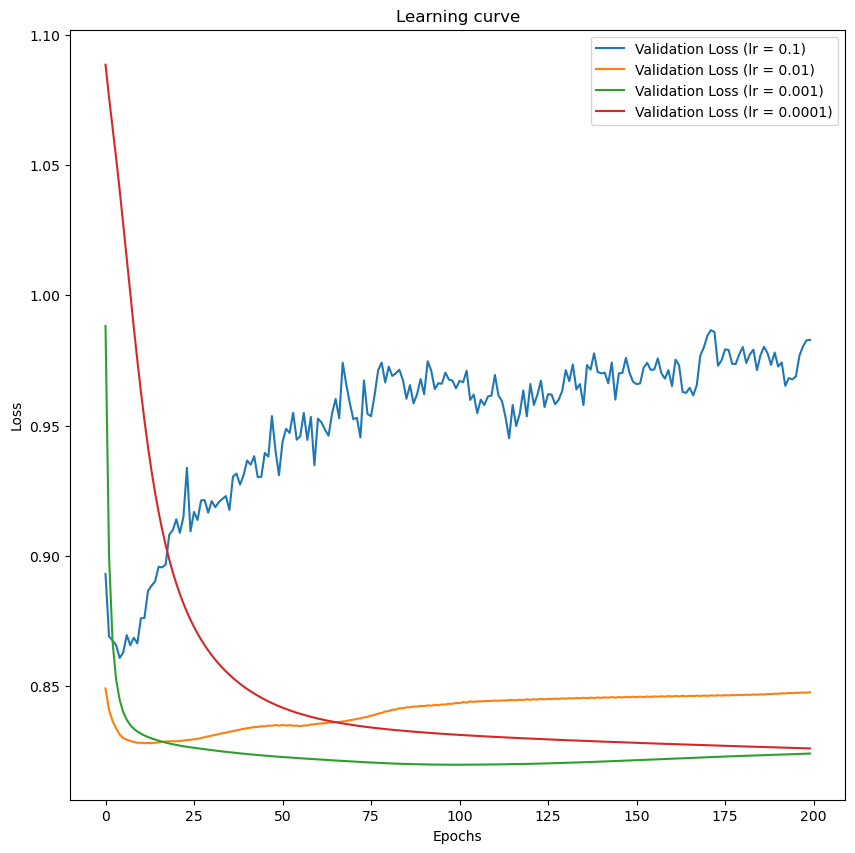

In [185]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
#ax.plot(train_score[0.1],label='Train Loss (lr = 0.1)',linestyle='--')
ax.plot(val_loss[0.1],label='Validation Loss (lr = 0.1)')
#ax.plot(train_score[0.01],label='Train Loss (lr = 0.01)',linestyle='--')
ax.plot(val_loss[0.01],label='Validation Loss (lr = 0.01)')
#ax.plot(train_score[0.001],label='Train Loss (lr = 0.001)',linestyle='--')
ax.plot(val_loss[0.001],label='Validation Loss (lr = 0.001)')
ax.plot(val_loss[0.0001],label='Validation Loss (lr = 0.0001)')
ax.set_title('Learning curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

In [186]:
## Two learning rates

train_score = {}
val_score = {}
loss_track = {}
val_loss = {}
Epochs = 200

best_loss_val = []
best_loss_train = []
best_acc_val = []
best_acc_train = []
for acti in np.linspace(0.0001,0.1,50):

    network = Net(n_input,n_hidden,n_output)

    optimizer = torch.optim.Adam(network.parameters(),lr=acti)
    #optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
    loss = torch.nn.CrossEntropyLoss()

    train_score[acti] = []
    val_score[acti] = []
    loss_track[acti] = []
    val_loss[acti] = []

    for epoch in range(Epochs):
        
        for _,data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data
        
        
            optimizer.zero_grad()
            outputs = network(inputs)
            l = loss(outputs,labels)
            l.backward()
            optimizer.step()
        
        
        #Compute accuracy
        y_pred_train = network(X_train)
        y_pred_val = network(X_val)
        
        val_loss[acti].append(loss(y_pred_val,y_val).item())
        loss_track[acti].append(loss(y_pred_train,y_train).item())
        
        y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
        y_pred_train = torch.argmax(y_pred_train,dim=1)
        
        y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
        y_pred_val = torch.argmax(y_pred_val,dim=1)
        
        train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
        val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
        
        train_score[acti].append(train_acc.item())
        val_score[acti].append(val_acc.item())
        
    
    
        

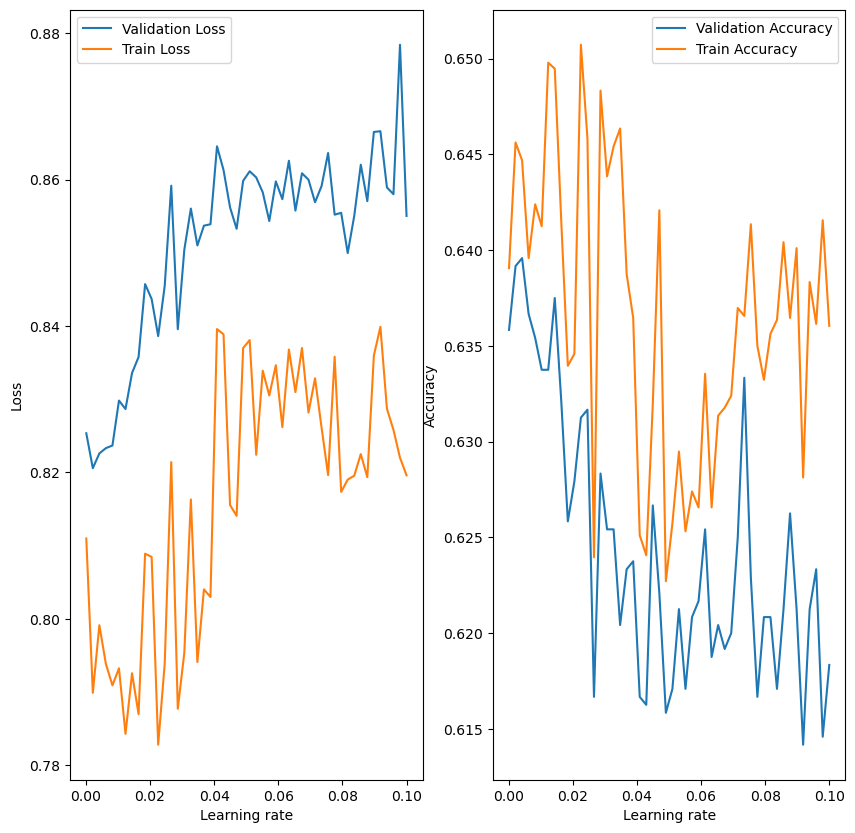

In [194]:
### For each learning rate, get the best validation loss and accuracy, and get the corresponding train loss and accuracy
best_loss_val = []
best_loss_train = []
best_acc_val = []
best_acc_train = []

for acti in np.linspace(0.0001,0.1,50):
    best_loss_val.append(np.min(val_loss[acti]))
    best_loss_train.append(loss_track[acti][np.argmin(val_loss[acti])])
    best_acc_val.append(np.max(val_score[acti]))
    best_acc_train.append(train_score[acti][np.argmax(val_score[acti])])
    
fig,ax = plt.subplots(1,2,figsize=(10,10))

#First plot is the loss, second is the accuracy

ax[0].plot(np.linspace(0.0001,0.1,50),best_loss_val,label='Validation Loss')
ax[0].plot(np.linspace(0.0001,0.1,50),best_loss_train,label='Train Loss')


ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Loss')

ax[0].legend()

ax[1].plot(np.linspace(0.0001,0.1,50),best_acc_val,label='Validation Accuracy')
ax[1].plot(np.linspace(0.0001,0.1,50),best_acc_train,label='Train Accuracy')


ax[1].set_xlabel('Learning rate')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [196]:
## Print the best learning rate
best_lr = np.linspace(0.0001,0.1,50)[np.argmin(best_loss_val)]

#Best epoch for that learning rate
min_epoch = np.argmin(val_loss[best_lr])

print('Best learning rate: {}'.format(best_lr))
print('Best epoch: {}'.format(min_epoch))

Best learning rate: 0.0021387755102040816
Best epoch: 55


### batvh size tuning

In [198]:
batch_size = [2,4,8,16,32,64,128,256,512,1024] 

train_score = {}
val_score = {}
loss_track = {}
val_loss = {}


for acti in batch_size:
    from torch.utils.data import DataLoader
    train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train,y_train),batch_size=acti,shuffle=False)
    
    network = Net(n_input,n_hidden,n_output)

    optimizer = torch.optim.Adam(network.parameters(),lr=best_lr)
    #optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
    loss = torch.nn.CrossEntropyLoss()

    train_score[acti] = []
    val_score[acti] = []
    loss_track[acti] = []
    val_loss[acti] = []
    Epochs = 75

    for epoch in range(Epochs):
        
        for _,data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data
        
        
            optimizer.zero_grad()
            outputs = network(inputs)
            l = loss(outputs,labels)
            l.backward()
            optimizer.step()
        
        
        #Compute accuracy
        y_pred_train = network(X_train)
        y_pred_val = network(X_val)
        
        val_loss[acti].append(loss(y_pred_val,y_val).item())
        loss_track[acti].append(loss(y_pred_train,y_train).item())
        
        y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
        y_pred_train = torch.argmax(y_pred_train,dim=1)
        
        y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
        y_pred_val = torch.argmax(y_pred_val,dim=1)
        
        train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
        val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
        
        train_score[acti].append(train_acc.item())
        val_score[acti].append(val_acc.item())
        
        
        
        

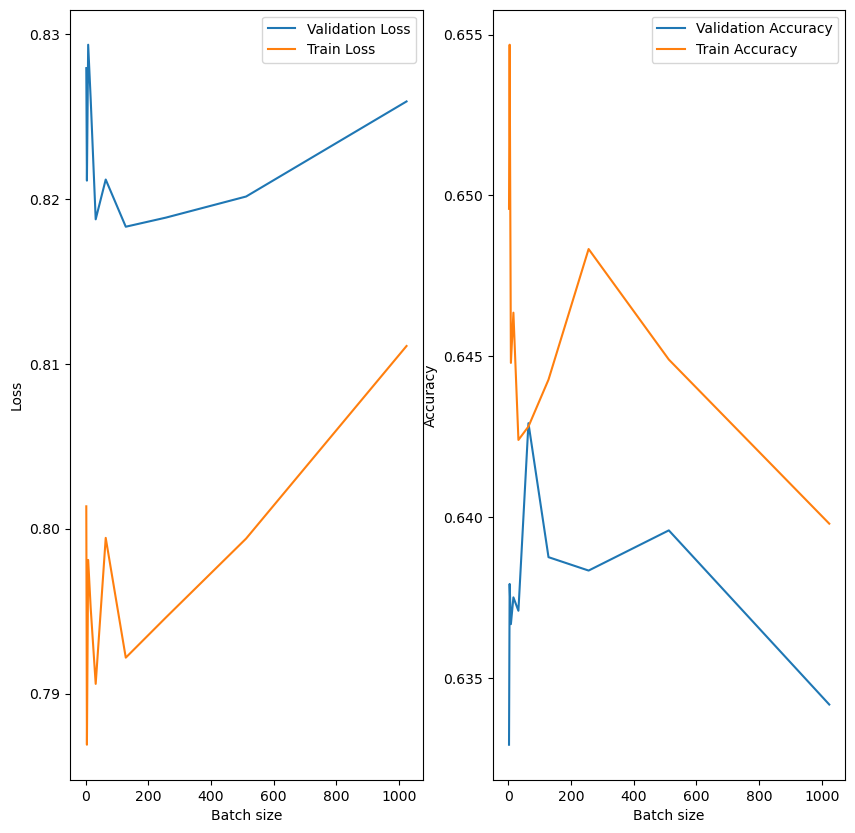

In [201]:
best_loss_val = []
best_loss_train = []
best_acc_val = []
best_acc_train = []

for acti in batch_size:
    best_loss_val.append(np.min(val_loss[acti]))
    best_loss_train.append(loss_track[acti][np.argmin(val_loss[acti])])
    best_acc_val.append(np.max(val_score[acti]))
    best_acc_train.append(train_score[acti][np.argmax(val_score[acti])])
    
fig,ax = plt.subplots(1,2,figsize=(10,10))

#First plot is the loss, second is the accuracy

ax[0].plot(batch_size,best_loss_val,label='Validation Loss')
ax[0].plot(batch_size,best_loss_train,label='Train Loss')


ax[0].set_xlabel('Batch size')
ax[0].set_ylabel('Loss')

ax[0].legend()

ax[1].plot(batch_size,best_acc_val,label='Validation Accuracy')
ax[1].plot(batch_size,best_acc_train,label='Train Accuracy')


ax[1].set_xlabel('Batch size')
ax[1].set_ylabel('Accuracy')

ax[1].legend()

plt.show()
    
    
    
    

Hidden size tuning ? :

In [71]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train,y_train),batch_size=64,shuffle=False)
val_dataloader = DataLoader(torch.utils.data.TensorDataset(X_val,y_val),batch_size=64,shuffle=False)

In [111]:
## Two learning rates

train_score_hidden = {}
val_score_hidden = {}
loss_track_hidden = {}
val_loss_hidden = {}
Epochs = 200

acti = torch.nn.functional.sigmoid
for hidden in [4,8,16,32,64,128,256,512,1024]:

    network = Net(n_input,hidden,n_output,acti)

    optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
    #optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
    loss = torch.nn.CrossEntropyLoss()

    train_score_hidden[hidden] = []
    val_score_hidden[hidden] = []
    loss_track_hidden[hidden] = []
    val_loss_hidden[hidden] = []

    for epoch in range(Epochs):
        if epoch > 100 and val_score_hidden[hidden][-1] < val_score_hidden[hidden][-2] and val_score_hidden[hidden][-2] < val_score_hidden[hidden][-3] and val_score_hidden[hidden][-3] < val_score_hidden[hidden][-4] and val_score_hidden[hidden][-4] < val_score_hidden[hidden][-5]:
            print(f'{hidden}Early stopping at epoch {epoch}')
            print(f'Best score : {max(val_score_hidden[hidden])} at epoch {np.argmax(val_score_hidden[hidden])}')
            break
        
        for _,data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data
        
        
            optimizer.zero_grad()
            outputs = network(inputs)
            l = loss(outputs,labels.float())
            l.backward()
            optimizer.step()
        
        
        #Compute accuracy
        y_pred_train = network(X_train)
        y_pred_val = network(X_val)
        
        val_loss_hidden[hidden].append(loss(y_pred_val,y_val.float()).item())
        loss_track_hidden[hidden].append(loss(y_pred_train,y_train.float()).item())
        
        y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
        y_pred_train = torch.argmax(y_pred_train,dim=1)
        
        y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
        y_pred_val = torch.argmax(y_pred_val,dim=1)
        
        train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
        val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
        
        train_score_hidden[hidden].append(train_acc.item())
        val_score_hidden[hidden].append(val_acc.item())
        
        
        if epoch % 74 == 0:
            print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
            print('Test accuracy: {}'.format(val_acc.item()))
            print('Train accuracy: {}'.format(train_acc.item()))
            print('------------')

Epoch: 0 - Loss: 0.833601713180542
Test accuracy: 0.6233333349227905
Train accuracy: 0.6302083134651184
------------
Epoch: 74 - Loss: 0.7555471658706665
Test accuracy: 0.6362500190734863
Train accuracy: 0.643541693687439
------------
Epoch: 148 - Loss: 0.7385047078132629
Test accuracy: 0.6366666555404663
Train accuracy: 0.6423958539962769
------------
Epoch: 0 - Loss: 0.8198693990707397
Test accuracy: 0.6254166960716248
Train accuracy: 0.6358333230018616
------------
Epoch: 74 - Loss: 0.7151513695716858
Test accuracy: 0.6345833539962769
Train accuracy: 0.6499999761581421
------------
8Early stopping at epoch 114
Best score : 0.6387500166893005 at epoch 59
Epoch: 0 - Loss: 0.8381133675575256
Test accuracy: 0.6200000047683716
Train accuracy: 0.6272916793823242
------------
Epoch: 74 - Loss: 0.7311505675315857
Test accuracy: 0.6179166436195374
Train accuracy: 0.6583333611488342
------------
Epoch: 148 - Loss: 0.7061792612075806
Test accuracy: 0.6137499809265137
Train accuracy: 0.66458332

In [126]:
#print best score for each hidden layer
for hidden in [4,8,16,32,64,128,256,512,1024]:
    print(f'Best score for {hidden} hidden layers : {max(val_score_hidden[hidden])} at epoch {np.argmax(val_score_hidden[hidden])}')
    #print corresponding train score
    print(f'Corresponding train score : {train_score_hidden[hidden][np.argmax(val_score_hidden[hidden])]}')

Best score for 4 hidden layers : 0.6395833492279053 at epoch 94
Corresponding train score : 0.6448958516120911
Best score for 8 hidden layers : 0.6387500166893005 at epoch 59
Corresponding train score : 0.6468750238418579
Best score for 16 hidden layers : 0.6358333230018616 at epoch 7
Corresponding train score : 0.64041668176651
Best score for 32 hidden layers : 0.6324999928474426 at epoch 11
Corresponding train score : 0.6428124904632568
Best score for 64 hidden layers : 0.6266666650772095 at epoch 20
Corresponding train score : 0.6584374904632568
Best score for 128 hidden layers : 0.6200000047683716 at epoch 5
Corresponding train score : 0.629895806312561
Best score for 256 hidden layers : 0.628333330154419 at epoch 9
Corresponding train score : 0.6423958539962769
Best score for 512 hidden layers : 0.6320833563804626 at epoch 1
Corresponding train score : 0.6420833468437195
Best score for 1024 hidden layers : 0.6291666626930237 at epoch 5
Corresponding train score : 0.646250009536743

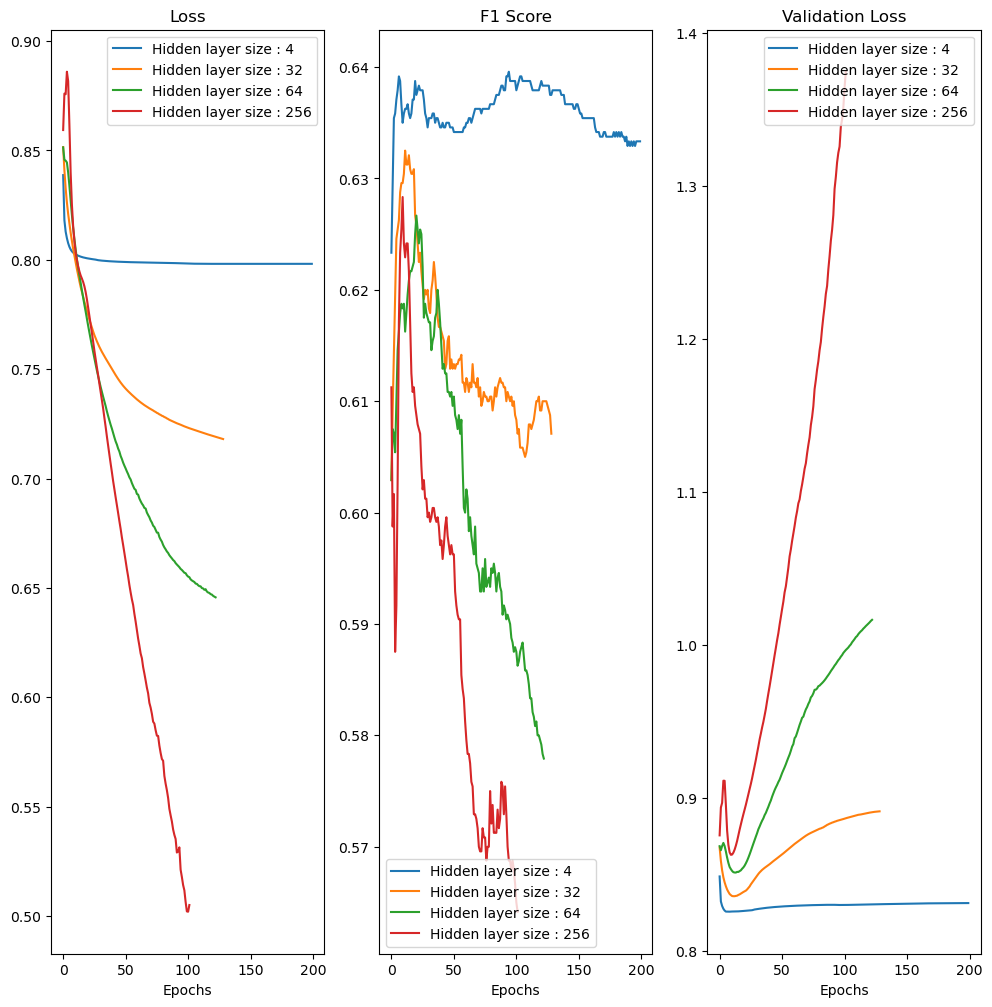

In [112]:
### Plot learning curves for different hidden layer sizes
fig, ax = plt.subplots(1,3,figsize=(12,12))

for hidden in [4,32,64,256]:
    ax[0].plot(loss_track_hidden[hidden],label=f'Hidden layer size : {hidden}')
    ax[1].plot(val_score_hidden[hidden],label=f'Hidden layer size : {hidden}')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Loss')
    ax[1].set_title('F1 Score')
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    
    #plot validation loss
    ax[2].plot(val_loss_hidden[hidden][:300],label=f'Hidden layer size : {hidden}')
    ax[2].legend()
    ax[2].set_title('Validation Loss')
    ax[2].set_xlabel('Epochs')

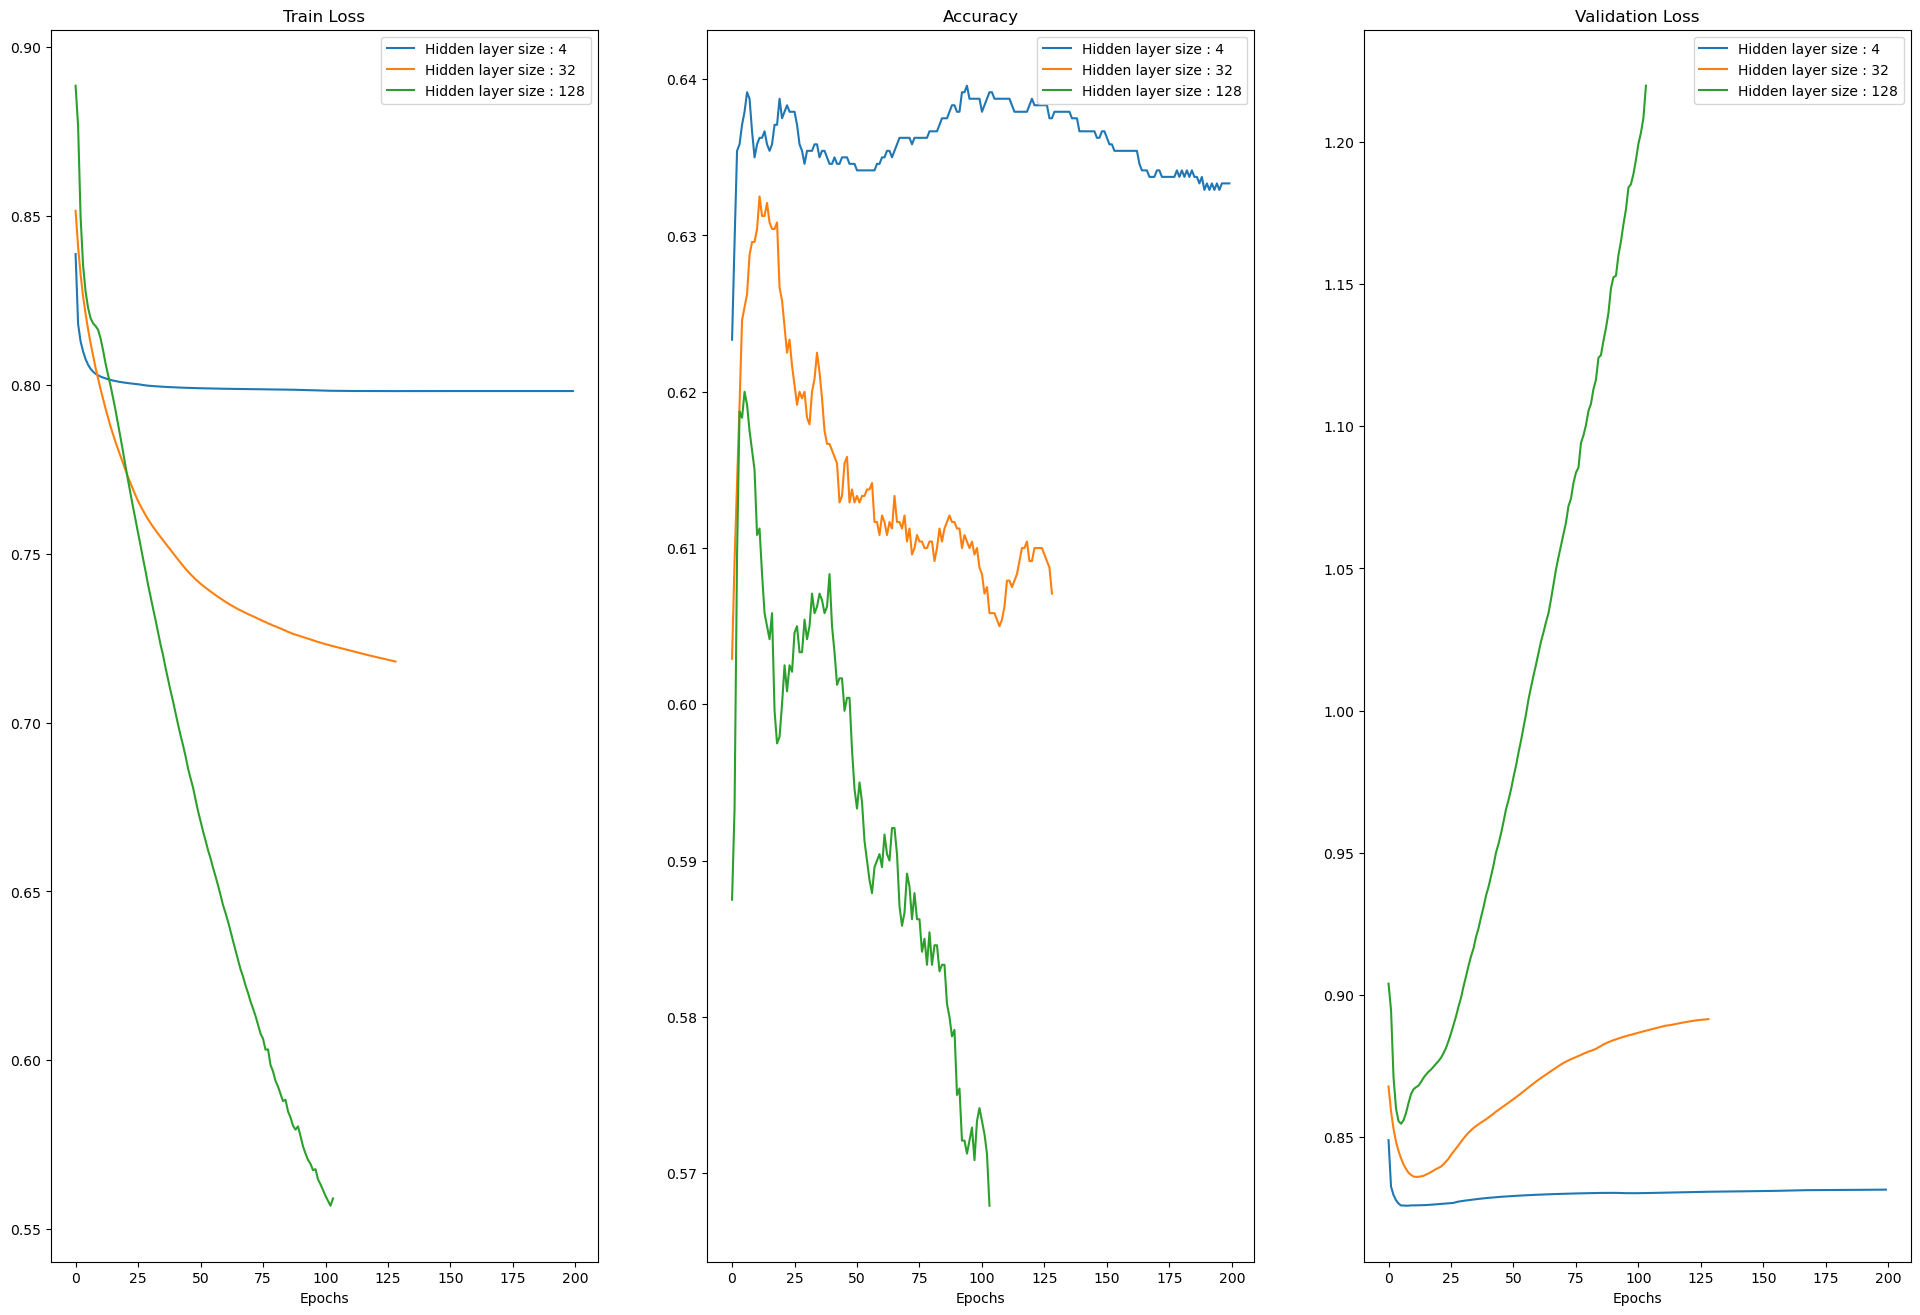

In [125]:
### Plot learning curves for different hidden layer sizes
fig, ax = plt.subplots(1,3,figsize=(24,16))

for hidden in [4,32,128]:
    ax[0].plot(loss_track_hidden[hidden],label=f'Hidden layer size : {hidden}')
    ax[1].plot(val_score_hidden[hidden],label=f'Hidden layer size : {hidden}')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Train Loss')
    ax[1].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    
    #plot validation loss
    ax[2].plot(val_loss_hidden[hidden][:300],label=f'Hidden layer size : {hidden}')
    ax[2].legend()
    ax[2].set_title('Validation Loss')
    ax[2].set_xlabel('Epochs')

## Deeper network

In [63]:
n_input = X_train.shape[1]
n_hidden1 =  256
n_hidden2 = n_hidden1
n_output = 3

class Net2(torch.nn.Module):
    def __init__(self,n_input,n_hidden1,n_hidden2,n_output,activation = torch.nn.functional.tanh):
        super(Net2,self).__init__()
        self.hidden1 = torch.nn.Linear(n_input,n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1,n_hidden2)
        self.activation = activation
        self.dropout = torch.nn.Dropout(0.2)
        
        self.out = torch.nn.Linear(n_hidden2,n_output)
        
    def forward(self,x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        #x = torch.nn.functional.sigmoid(self.hidden2(x))
        x = self.dropout(x)
        x = self.out(x)
        #x = torch.nn.functional.softmax(x,dim=1)
        return x

In [120]:
## Two learning rates

train_score_hidden2 = {}
val_score_hidden2 = {}
loss_track_hidden2 = {}
val_loss_hidden2 = {}
Epochs = 300

acti = torch.nn.functional.sigmoid
for hidden in [4,8,16,32,64,128,256,512,1024]:

    network = Net2(n_input,hidden,hidden,n_output,acti)

    optimizer = torch.optim.Adam(network.parameters(),lr=0.001)
    #optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
    loss = torch.nn.CrossEntropyLoss()

    train_score_hidden2[hidden] = []
    val_score_hidden2[hidden] = []
    loss_track_hidden2[hidden] = []
    val_loss_hidden2[hidden] = []

    for epoch in range(Epochs):
        
        for _,data in enumerate(train_dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data
        
        
            optimizer.zero_grad()
            outputs = network(inputs)
            l = loss(outputs,labels.float())
            l.backward()
            optimizer.step()
        
        
        #Compute accuracy
        y_pred_train = network(X_train)
        y_pred_val = network(X_val)
        
        val_loss_hidden2[hidden].append(loss(y_pred_val,y_val.float()).item())
        loss_track_hidden2[hidden].append(loss(y_pred_train,y_train.float()).item())
        
        y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
        y_pred_train = torch.argmax(y_pred_train,dim=1)
        
        y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
        y_pred_val = torch.argmax(y_pred_val,dim=1)
        
        train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
        val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
        
        train_score_hidden2[hidden].append(train_acc.item())
        val_score_hidden2[hidden].append(val_acc.item())
        
        
        if epoch % 74 == 0:
            print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
            print('Test accuracy: {}'.format(val_acc.item()))
            print('Train accuracy: {}'.format(train_acc.item()))
            print('------------')

Epoch: 0 - Loss: 0.9220762848854065
Test accuracy: 0.5425000190734863
Train accuracy: 0.5528125166893005
------------
Epoch: 74 - Loss: 0.7222384810447693
Test accuracy: 0.6324999928474426
Train accuracy: 0.6518750190734863
------------
Epoch: 148 - Loss: 0.6400845646858215
Test accuracy: 0.6241666674613953
Train accuracy: 0.6806250214576721
------------
Epoch: 222 - Loss: 0.5541213750839233
Test accuracy: 0.6162499785423279
Train accuracy: 0.7106249928474426
------------
Epoch: 296 - Loss: 0.5058572888374329
Test accuracy: 0.5858333110809326
Train accuracy: 0.7387499809265137
------------
Epoch: 0 - Loss: 0.9036354422569275
Test accuracy: 0.5479166507720947
Train accuracy: 0.5625
------------
Epoch: 74 - Loss: 0.7163205146789551
Test accuracy: 0.6308333277702332
Train accuracy: 0.6579166650772095
------------
Epoch: 148 - Loss: 0.5969977378845215
Test accuracy: 0.60916668176651
Train accuracy: 0.7032291889190674
------------
Epoch: 222 - Loss: 0.4226894974708557
Test accuracy: 0.58291

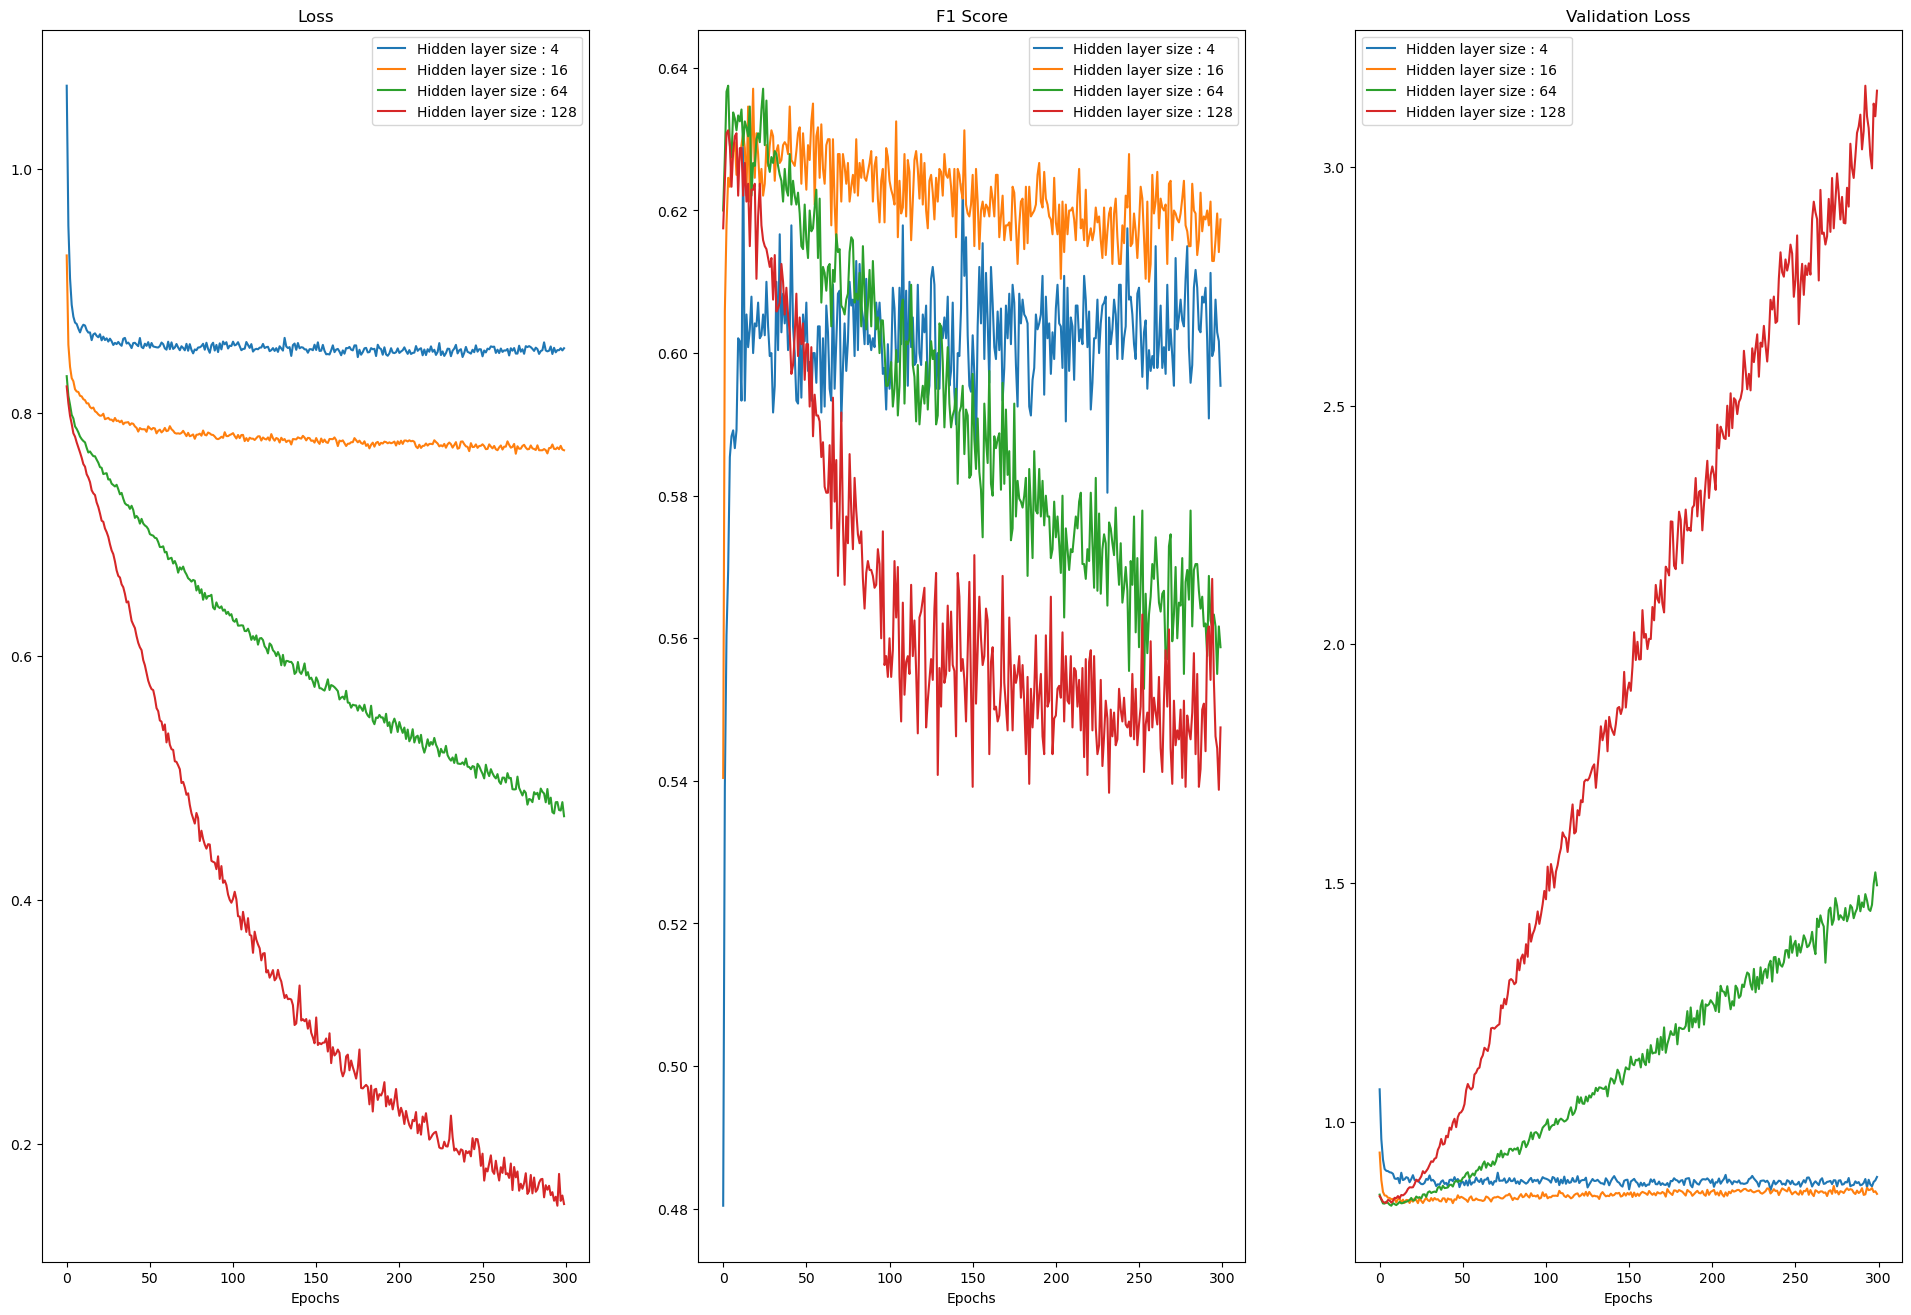

In [69]:
### Plot learning curves for different hidden layer sizes
fig, ax = plt.subplots(1,3,figsize=(24,16))

for hidden in [4,8,16]:
    ax[0].plot(loss_track_hidden[hidden],label=f'Hidden layer size : {hidden}')
    ax[1].plot(val_score_hidden[hidden],label=f'Hidden layer size : {hidden}')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('Loss')
    ax[1].set_title('F1 Score')
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    
    #plot validation loss
    ax[2].plot(val_loss_hidden[hidden][:300],label=f'Hidden layer size : {hidden}')
    ax[2].legend()
    ax[2].set_title('Validation Loss')
    ax[2].set_xlabel('Epochs')

In [127]:
#for each hidden size, print best val accuracy and the associated epoch

for hidden in [4,8,16,32,64,128,256,512,1024]:
    
    print(f'Best score : {max(val_score_hidden2[hidden])} at epoch {np.argmax(val_score_hidden2[hidden])}')
    print(f'Corresponding train score : {train_score_hidden2[hidden][np.argmax(val_score_hidden2[hidden])]}')
    
   

Best score : 0.6229166388511658 at epoch 236
Corresponding train score : 0.6156250238418579
Best score : 0.6391666531562805 at epoch 160
Corresponding train score : 0.6328125
Best score : 0.6454166769981384 at epoch 95
Corresponding train score : 0.643958330154419
Best score : 0.6429166793823242 at epoch 44
Corresponding train score : 0.643750011920929
Best score : 0.6433333158493042 at epoch 115
Corresponding train score : 0.6590625047683716
Best score : 0.64083331823349 at epoch 37
Corresponding train score : 0.6442708373069763
Best score : 0.64083331823349 at epoch 44
Corresponding train score : 0.6526041626930237


KeyError: 512

# best model

In [128]:


network = Net(n_input,4,n_output)

optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
#optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
loss = torch.nn.CrossEntropyLoss()

train_score = []
val_score = []
loss_track = []
val_loss = []

for epoch in range(Epochs):
   
    
    for _,data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
    
    
        optimizer.zero_grad()
        outputs = network(inputs)
        l = loss(outputs,labels.float())
        l.backward()
        optimizer.step()
    
    
    #Compute accuracy
    y_pred_train = network(X_train)
    y_pred_val = network(X_val)
    
    val_loss_hidden[hidden].append(loss(y_pred_val,y_val.float()).item())
    loss_track_hidden[hidden].append(loss(y_pred_train,y_train.float()).item())
    
    y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
    y_pred_train = torch.argmax(y_pred_train,dim=1)
    
    y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
    y_pred_val = torch.argmax(y_pred_val,dim=1)
    
    train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
    val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
    
    train_score_hidden[hidden].append(train_acc.item())
    val_score_hidden[hidden].append(val_acc.item())
    
    
    if epoch % 10 == 0:
        print('Epoch: {} - Loss: {}'.format(epoch,l.item()))
        print('Test accuracy: {}'.format(val_acc.item()))
        print('Train accuracy: {}'.format(train_acc.item()))
        print('------------')

Epoch: 0 - Loss: 0.8363137245178223
Test accuracy: 0.6225000023841858
Train accuracy: 0.6310416460037231
------------
Epoch: 10 - Loss: 0.7564601302146912
Test accuracy: 0.6324999928474426
Train accuracy: 0.6407291889190674
------------
Epoch: 20 - Loss: 0.755095899105072
Test accuracy: 0.6349999904632568
Train accuracy: 0.6415625214576721
------------
Epoch: 30 - Loss: 0.7425951957702637
Test accuracy: 0.6370833516120911
Train accuracy: 0.6424999833106995
------------
Epoch: 40 - Loss: 0.7284038066864014
Test accuracy: 0.6370833516120911
Train accuracy: 0.6444791555404663
------------
Epoch: 50 - Loss: 0.7286638021469116
Test accuracy: 0.6358333230018616
Train accuracy: 0.645104169845581
------------
Epoch: 60 - Loss: 0.7304868102073669
Test accuracy: 0.6362500190734863
Train accuracy: 0.645104169845581
------------
Epoch: 70 - Loss: 0.7323423027992249
Test accuracy: 0.6341666579246521
Train accuracy: 0.6452083587646484
------------
Epoch: 80 - Loss: 0.729703426361084
Test accuracy: 0

# 50 epoch seems enough

In [129]:


network = Net(n_input,4,n_output)

optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
#optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
loss = torch.nn.CrossEntropyLoss()

train_score = []
val_score = []
loss_track = []
val_loss = []

for epoch in range(50):
   
    
    for _,data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
    
    
        optimizer.zero_grad()
        outputs = network(inputs)
        l = loss(outputs,labels.float())
        l.backward()
        optimizer.step()
    
    
    #Compute accuracy
    y_pred_train = network(X_train)
    y_pred_val = network(X_val)
    
    val_loss_hidden[hidden].append(loss(y_pred_val,y_val.float()).item())
    loss_track_hidden[hidden].append(loss(y_pred_train,y_train.float()).item())
    
    y_pred_train = torch.nn.functional.softmax(y_pred_train,dim=1)
    y_pred_train = torch.argmax(y_pred_train,dim=1)
    
    y_pred_val = torch.nn.functional.softmax(y_pred_val,dim=1)
    y_pred_val = torch.argmax(y_pred_val,dim=1)
    
    train_acc = (y_pred_train == torch.argmax(y_train,dim=1)).float().mean()
    val_acc = (y_pred_val == torch.argmax(y_val,dim=1)).float().mean()
    
    train_score_hidden[hidden].append(train_acc.item())
    val_score_hidden[hidden].append(val_acc.item())
    
    
    

In [130]:
#score on test set
y_pred_test = network(X_test)
y_pred_test = torch.nn.functional.softmax(y_pred_test,dim=1)
y_pred_test = torch.argmax(y_pred_test,dim=1)

test_acc = (y_pred_test == torch.argmax(y_test,dim=1)).float().mean()
test_acc.item()

0.6333333253860474